### This is the continuatation from the oncloud XGBoost project part, we already have setupped the project, this part only contains the classification.

In [2]:
### Extract Zip Files in AWS One time only.
import zipfile
zip_file_path = 'combined1.zip' 
extracted_dir = 'zipExtract/' 
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

zip_file_path = 'combined2.zip' 
extracted_dir = 'zipExtract/' 
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

Loading the required library 

In [1]:
# import required Library
import pandas as pd
import numpy as np
import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import warnings, requests, zipfile, io
from sagemaker import image_uris
from sagemaker.estimator import Estimator
from sklearn.metrics import accuracy_score
session = sagemaker.Session()
bucket = session.default_bucket()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Loading the both version of the CSV files from the PART A 

In [3]:
df1 = pd.read_csv("zipExtract/combined_csv_v1.csv",low_memory=False)
df1 = df1.replace({True: 1, False: 0})
df2 = pd.read_csv("zipExtract/combined_csv_v2.csv",low_memory=False)
df2 = df2.replace({True: 1, False: 0})

In [4]:
#df1 = df1.replace({True: 1, False: 0})
df1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,0.0,1464.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.0,1464.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1464.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,1464.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,1464.0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 1. Split data into training, validation and testing sets (70% - 15% - 15%). ---- CSV Version 1

In [5]:
### Split Data into training, Validation & tesing set (70-15-15)% for data 1 version 1
train, test_and_validate = train_test_split(df1, test_size=0.3)
test, validate = train_test_split(test_and_validate, test_size=0.5)
train_file = 'train.csv'
test_file = 'test.csv'
validate_file = 'validate.csv'

In [6]:
x_test = test.drop("target", axis =1)
y_test = test["target"]
directory_path = 'csvfile/a'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'train_file')

with open(file_path, 'w') as file:
   file.write('This is some content.')

train.to_csv("csvfile/a/train.csv", index = False, header = False)
validate.to_csv("csvfile/a/validation.csv", index = False, header = False)
test.to_csv("csvfile/a/test.csv", index = False, header = False)

### 2 Use the linear learner estimator to build a classification model

In [7]:
linear_learner_container = image_uris.retrieve("linear-learner", region)

In [8]:
### Uploading in AWS S3
prefix = "data_delay/a/"
train_path = session.upload_data(path="csvfile/a/train.csv", key_prefix=prefix + "input/training")
valid_path = session.upload_data(path="csvfile/a/validation.csv", key_prefix=prefix + "input/validation" )
test_path = session.upload_data(path="csvfile/a/test.csv", key_prefix=prefix + "input/test" )

In [ ]:
print(train_path)
print(valid_path)
print(test_path)
print("Files successfully uploaded in AWS SERVER !!!")

In [10]:
linear_model1 = Estimator(linear_learner_container, 
                              role=sagemaker.get_execution_role(), 
                              instance_count=1, 
                              instance_type='ml.m5.2xlarge',
                            output_path='s3://{}/{}a/output'.format(bucket,prefix))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Hyperparameter setting - To fasten the training process we used the batch size of 1000 and epochs 1

In [11]:
### Hyperparameter setting
linear_model1.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=1000, num_models=1, num_classes=2,epochs=1)


In [12]:
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')

In [13]:
#data_channels = {'train': train_channel, 'validation': validate_channel}
linear_model1.fit({'train': training_data_channel,'validation': validation_data_channel})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-04-09-07-48-399


2023-11-04 09:07:48 Starting - Starting the training job...
2023-11-04 09:08:03 Starting - Preparing the instances for training......
2023-11-04 09:09:06 Downloading - Downloading input data......
2023-11-04 09:09:52 Training - Downloading the training image...
2023-11-04 09:10:22 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/04/2023 09:10:47 INFO 139793846245184] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': '

### 3. Host the model on another instance

In [14]:
### Host the Model on another instance
xgb_predictor = linear_model1.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: xgboost-2023-11-04-02-07-22-749
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-11-04-02-07-22-749
INFO:sagemaker:Creating endpoint with name xgboost-2023-11-04-02-07-22-749


-----!

### Perform Batch transform and evaluate model on testing Data.

In [15]:
### Perform Batch transform and evaluate model on testing Data.
transformer = linear_model1.transformer(
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}output"
)

INFO:sagemaker:Creating model with name: linear-learner-2023-11-04-09-14-56-375


In [ ]:
y_file = boto3.client("s3").get_object(Bucket = bucket, Key = f"{prefix}/batch_input.csv.out")
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header = None, names = ["Predicted"])

In [ ]:
y_pred["target"] = y_pred.index

### 5. Report the performance metrics that you see better test the model performance 

In [34]:
### Model Evaluation
### Calculating Accuracy
predicted_values = y_pred['target'].apply(lambda x: 1 if x == 1 else 0)
accuracy = accuracy_score(y_test, y_pred["actual"])
print("Accuracy:", accuracy)

Accuracy: 0.7908355004116769


INFO:matplotlib.font_manager:generated new fontManager


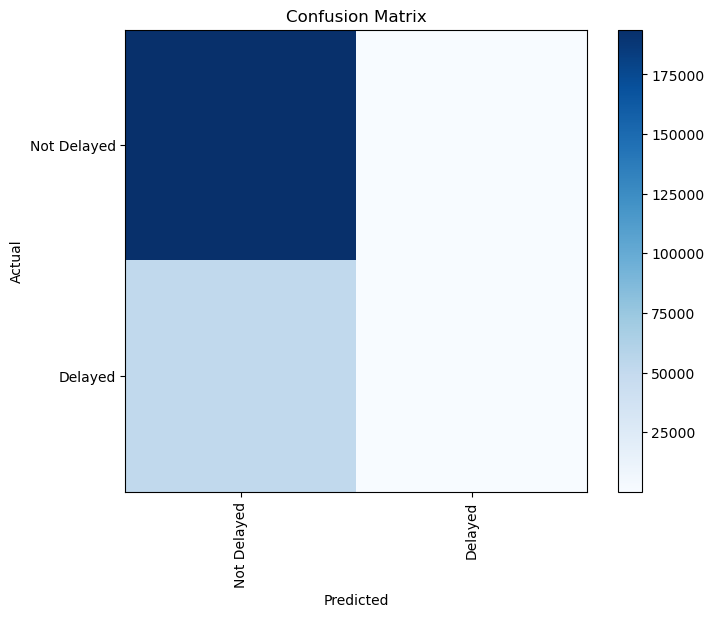

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_test, y_pred["actual"])
df_confusion = pd.DataFrame(matrix, index=['Not Delayed','Delayed'],columns=['Not Delayed','Delayed'])
plt.figure(figsize=(8, 6))
plt.imshow(df_confusion, cmap='Blues', interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_confusion))]
plt.xticks(tick_marks, df_confusion.columns, rotation='vertical')
plt.yticks(tick_marks, df_confusion.index)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 1. Split data into training, validation and testing sets (70% - 15% - 15%). ---- CSV Version 2

In [ ]:
### Split Data into training, Validation & tesing set (70-15-15)% for data 1 version 2
train, test_and_validate = train_test_split(df2, test_size=0.3) ### df2 for data version 2 from part 1
test, validate = train_test_split(test_and_validate, test_size=0.5)
train_file = 'train.csv'
test_file = 'test.csv'
validate_file = 'validate.csv'

In [ ]:
x_test = test.drop("target", axis =1)
y_test = test["target"]
directory_path = 'csvfile/a'

# Check if the directory exists, and if not, create it
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

file_path = os.path.join(directory_path, 'train_file')

with open(file_path, 'w') as file:
   file.write('This is some content.')

train.to_csv("csvfile/a/train.csv", index = False, header = False)
validate.to_csv("csvfile/a/validation.csv", index = False, header = False)
test.to_csv("csvfile/a/test.csv", index = False, header = False)

### 2 Use the linear learner estimator to build a classification model

In [ ]:
linear_learner_container = image_uris.retrieve("linear-learner", region)

In [ ]:
### Uploading in AWS S3
prefix = "data_delay/a/"
train_path = session.upload_data(path="csvfile/a/train.csv", key_prefix=prefix + "input/training")
valid_path = session.upload_data(path="csvfile/a/validation.csv", key_prefix=prefix + "input/validation" )
test_path = session.upload_data(path="csvfile/a/test.csv", key_prefix=prefix + "input/test" )

In [ ]:
print(train_path)
print(valid_path)
print(test_path)
print("Files successfully uploaded in AWS SERVER !!!")

In [ ]:
linear_model2 = Estimator(linear_learner_container, 
                              role=sagemaker.get_execution_role(), 
                              instance_count=1, 
                              instance_type='ml.m5.2xlarge',
                            output_path='s3://{}/{}a/output'.format(bucket,prefix))

### Hyperparameter setting - To fasten the training process we used the batch size of 1000 and epochs 1

In [ ]:
## Hyperparameter setting
linear_model1.set_hyperparameters(predictor_type='binary_classifier', mini_batch_size=1000, num_models=1, num_classes=2,epochs=1)


In [ ]:
training_data_channel = sagemaker.TrainingInput(s3_data=train_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=valid_path, content_type='text/csv')

In [ ]:
#data_channels = {'train': train_channel, 'validation': validate_channel}
linear_model2.fit({'train': training_data_channel,'validation': validation_data_channel})

### 3 Host the Model on another instance


In [ ]:
xgb_predictor = linear_model1.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

### 4 Perform Batch transform and evaluate model on testing Data.

In [ ]:
### Perform Batch transform and evaluate model on testing Data.
transformer = linear_model1.transformer(
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    assemble_with="Line",
    output_path=f"s3://{bucket}/{prefix}output"
)

In [ ]:
y_file = boto3.client("s3").get_object(Bucket = bucket, Key = f"{prefix}/batch_input.csv.out")
y_pred = pd.read_csv(io.BytesIO(y_file["Body"].read()), header = None, names = ["Predicted"])
y_pred

5. Report the performance metrics that you see better test the model performance 

In [2]:
### Model Evaluation
### Calculating Accuracy
predicted_values = y_pred['target'].apply(lambda x: 1 if x == 1 else 0)
accuracy = accuracy_score(y_test, y_pred["actual"])
print("Accuracy:", accuracy)


Accuracy: 0.79034
